## Regression (Linear or not) Using sklearn Boosting Regressors

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html

<pre>
-----------------------------------------------------------
Below are two simple examples of how Boosting Regressors work.

First example shows that a tree regressor can not extrapolate.
It can only interpolate. 
To manage extrapolation (for example, for time series prediction), 
you need to transform the data to remove the trend before 
training/predicting, and then add the trend(s) back.

Second example shows how some boosting algorithms can
handle missing data. Unfortunately these algorithms also 
can give "nonsense" predictions (for example, predict 
negative number of events). I show common workarounds.
-----------------------------------------------------------
</pre>
In real life you would need use proper train/test split and K-folding.
Better use a stratified version:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html



In [1]:
import os,sys, time, math
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.datasets import make_classification
# --------------------------------------
from xgboost.sklearn import XGBRegressor
# --------------------------------------
import catboost as cb  # pip isntall catboost
import lightgbm as lgb # pip install lightgbm 
# --------------------------------------
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
print('python',sys.version.split()[0])
print('np',np.__version__)
print('pd',pd.__version__)
print('sklearn',sklearn.__version__)
print('matplotlib',matplotlib.__version__)
print('sns',sns.__version__)

python 3.9.12
np 1.23.1
pd 1.4.3
sklearn 1.1.1
matplotlib 3.5.2
sns 0.11.2


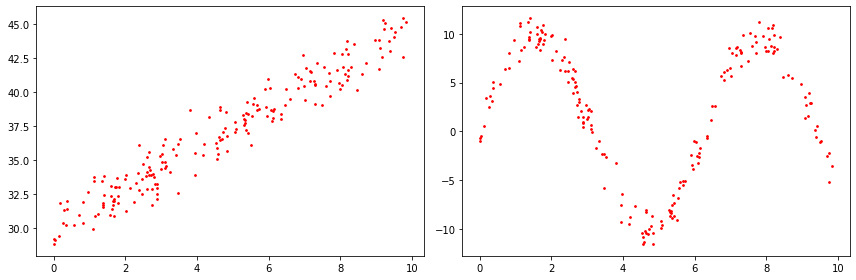

In [3]:
rng = np.random.RandomState(seed=None)
xx = 10 * rng.rand(200)                   # 200 random numbers in [0,10] 
a = 1.5
b = 30.0
noise = rng.normal(0,1,200)               # 200 normally distributed numbers
yy = a*xx + b + noise
zz = 10*np.sin(xx) + noise
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
_ = ax0, ax1 = axes.flatten()
_ = ax0.scatter(xx,yy,color="r", s=3)
_ = ax1.scatter(xx,zz,color="r", s=3)
fig.tight_layout()
plt.show() ;

In [4]:
# For regression model we have to reshape "features" as array of rows
xx2 = xx.reshape(-1, 1)
print("xx2 shape",xx2.shape)
print(xx2[:5])

xx2 shape (200, 1)
[[1.82403542]
 [3.10169956]
 [5.73907413]
 [1.36940884]
 [0.82289978]]


In [5]:
model_yy = XGBRegressor(learning_rate = 0.01, n_estimators = 400)
model_zz = XGBRegressor(learning_rate = 0.01, n_estimators = 400)

In [6]:
model_yy.fit(xx2, yy)
model_zz.fit(xx2, zz)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [7]:
# for prediciton, add "before" and "after" points 
xx_min = np.min(xx)
xx_max = np.max(xx)
print(f"xx_min = {xx_min:3f}, {xx_max:3f}")
extra_x = 5
xx3 = np.arange(start=xx_min-extra_x, stop=xx_max+extra_x, step=0.1)
mylen = len(xx3)
print(f"points: {mylen}")
print(f"xx3 in [{xx3[0]:3f}, {xx3[-1]:3f}]")

xx_min = 0.013133, 9.834787
points: 199
xx3 in [-4.986867, 14.813133]


In [8]:
# model needs 2-dim array of features
xx4 = np.array(xx3).reshape(-1, 1)
yy4 = model_yy.predict(xx4)
zz4 = model_zz.predict(xx4)

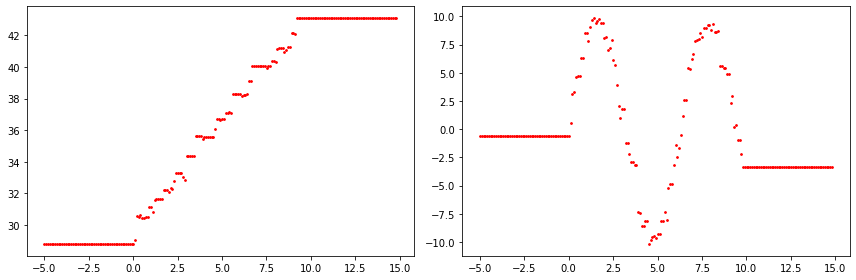

In [9]:
# Visualizing the regression line
# and showing how it can not extrapolate
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
_ = ax0, ax1 = axes.flatten()
_ = ax0.scatter(xx4,yy4,color="r", s=3)
_ = ax1.scatter(xx4,zz4,color="r", s=3)
fig.tight_layout()
plt.show() ;

## Boosted Trees predictions can be below min or above max training values

https://datascience.stackexchange.com/questions/77234/can-boosted-trees-predict-below-the-minimum-value-of-the-training-label/77272#77272


In [10]:
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost.sklearn import XGBRegressor

n_samples = 600
n_features = 6

X, y = make_classification(
    random_state=42, 
    n_samples=n_samples, 
    n_features=n_features
) 

print(f"{X.shape = }")
print(f"{y.shape = }")
# values are only 0 or 1
print(f"y min = {y.min():.5f}, max = {y.max():.5f}")

X.shape = (600, 6)
y.shape = (600,)
y min = 0.00000, max = 1.00000


In [11]:
# Some regressors can handle missing values.
# We will model it by randomly inserting np.nan

n_nulls = 1 # number of nulls per row

XT = np.copy(X) # for training
XP = np.copy(X) # for predicting

def add_nulls(data, n_features=n_features, n_nulls=0):
    idx = np.arange(n_features)
    if n_nulls > 0:
        for row in range(len(data)):
            idx2 = np.random.choice(idx, n_nulls)
            for ii in idx2:
                data[row,ii] = np.nan
    
# add nulls as needed
# add_nulls(XT)
add_nulls(XP)

list_depths = [1,2,5,10,20,50,100,200]

# -----------------------------------------------------
def myprint(max_depth, mymin, mymax, dt):    
    if mymin < 0:
        ss = f"\x1b[31m{mymin:.5f}\x1b[0m"  # red
    else:
        ss = f"{mymin:.5f}"
    print(f"{max_depth:3d}: {ss}, {preds.max():.5f}, {dt:4.3f} sec")

In [12]:
print("GradientBoostingRegressor - does not support nulls")
print("depth | min   | max.   | run time")
for max_depth in list_depths:
    t1 = time.time()
    model = GradientBoostingRegressor(max_depth=max_depth,
                                      n_estimators=10,
                                      learning_rate=1,
                                      random_state=42)
    model.fit(X,y)
    preds = model.predict(X) # this regressor does not support Nan values
    myprint(max_depth, preds.min(), preds.max(), time.time()-t1)

GradientBoostingRegressor - does not support nulls
depth | min   | max.   | run time
  1: -0.25665, 1.05701, 0.010 sec
  2: -0.18161, 1.30523, 0.007 sec
  5: -0.02606, 1.04776, 0.013 sec
 10: -0.00000, 1.00000, 0.003 sec
 20: -0.00000, 1.00000, 0.003 sec
 50: -0.00000, 1.00000, 0.003 sec
100: -0.00000, 1.00000, 0.003 sec
200: -0.00000, 1.00000, 0.003 sec


In [13]:
print("HistGradientBoostingRegressor with learning_rate = 0.1 (default)")
print("depth | min   | max.   | run time")
for max_depth in list_depths:
    t1 = time.time()
    model = HistGradientBoostingRegressor(max_depth=max_depth)
    model.fit(X,y)
    preds = model.predict(XP)
    myprint(max_depth, preds.min(), preds.max(), time.time()-t1)
print("HistGradientBoostingRegressor with learning_rate = 0.01")
print("depth | min   | max.   | run time")
for max_depth in list_depths:
    t1 = time.time()
    model = HistGradientBoostingRegressor(max_depth=max_depth, learning_rate=0.01)
    model.fit(X,y)
    preds = model.predict(XP)
    myprint(max_depth, preds.min(), preds.max(), time.time()-t1)
print("HistGradientBoostingRegressor with loss=poisson")
print("depth | min   | max.   | run time")
for max_depth in list_depths:
    t1 = time.time()
    model = HistGradientBoostingRegressor(max_depth=max_depth, loss='poisson', min_samples_leaf=2)
    model.fit(X,y)
    preds = model.predict(XP)
    myprint(max_depth, preds.min(), preds.max(), time.time()-t1)

HistGradientBoostingRegressor with learning_rate = 0.1 (default)
depth | min   | max.   | run time
  1: -0.31345, 1.00232, 0.308 sec
  2: -0.12167, 1.08984, 0.526 sec
  5: -0.09507, 1.10812, 1.624 sec
 10: -0.09418, 1.09082, 2.560 sec
 20: -0.06903, 1.09547, 3.042 sec
 50: -0.06903, 1.09547, 3.143 sec
100: -0.06903, 1.09547, 3.215 sec
200: -0.06903, 1.09547, 3.132 sec
HistGradientBoostingRegressor with learning_rate = 0.01
depth | min   | max.   | run time
  1: 0.22332, 0.75144, 0.256 sec
  2: 0.19633, 0.80271, 0.536 sec
  5: 0.17593, 0.82072, 1.651 sec
 10: 0.17591, 0.83030, 3.261 sec
 20: 0.17591, 0.83030, 3.079 sec
 50: 0.17591, 0.83030, 3.196 sec
100: 0.17591, 0.83030, 3.191 sec
200: 0.17591, 0.83030, 2.936 sec
HistGradientBoostingRegressor with loss=poisson
depth | min   | max.   | run time
  1: 0.00459, 0.96512, 0.269 sec
  2: 0.00041, 1.20172, 0.450 sec
  5: 0.00003, 1.09983, 1.924 sec
 10: 0.00002, 1.03552, 4.399 sec
 20: 0.00002, 1.02612, 4.804 sec
 50: 0.00002, 1.02612, 4.574

In [14]:
# XGBRegressor
# -----------------------------------------------------
print("XGBRegressor with learning_rate = 0.1 (default)")
print("depth | min   | max.   | run time")
for max_depth in list_depths:
    t1 = time.time()
    model = XGBRegressor(max_depth=max_depth)
    model.fit(X,y)
    preds = model.predict(XP)
    myprint(max_depth, preds.min(), preds.max(), time.time()-t1)
# -----------------------------------------------------
print("XGBRegressor with learning_rate = 0.01")
print("depth | min   | max.   | run time")
for max_depth in list_depths:
    t1 = time.time()
    model = XGBRegressor(max_depth=max_depth, learning_rate = 0.01)
    model.fit(X,y)
    preds = model.predict(XP)
    myprint(max_depth, preds.min(), preds.max(), time.time()-t1)
# -----------------------------------------------------
print("XGBRegressor objective count:poisson")
print("depth | min   | max.   | run time")
for max_depth in list_depths:
    t1 = time.time()
    model = XGBRegressor(max_depth=max_depth, objective='count:poisson')
    model.fit(X,y)
    preds = model.predict(XP)
    myprint(max_depth, preds.min(), preds.max(), time.time()-t1)

XGBRegressor with learning_rate = 0.1 (default)
depth | min   | max.   | run time
  1: -0.28201, 1.07795, 0.155 sec
  2: -0.13228, 1.13325, 0.140 sec
  5: -0.01358, 1.01583, 0.334 sec
 10: -0.00073, 1.00109, 0.243 sec
 20: -0.00053, 1.00110, 0.345 sec
 50: -0.00050, 1.00105, 0.355 sec
100: -0.00050, 1.00105, 0.283 sec
200: -0.00050, 1.00105, 0.331 sec
XGBRegressor with learning_rate = 0.01
depth | min   | max.   | run time
  1: 0.22497, 0.75227, 0.081 sec
  2: 0.19846, 0.80280, 0.114 sec
  5: 0.18305, 0.81129, 0.316 sec
 10: 0.18376, 0.81026, 0.524 sec
 20: 0.18376, 0.81025, 0.536 sec
 50: 0.18376, 0.81025, 0.529 sec
100: 0.18376, 0.81025, 0.567 sec
200: 0.18376, 0.81025, 0.615 sec
XGBRegressor objective count:poisson
depth | min   | max.   | run time
  1: 0.00335, 0.98195, 0.085 sec
  2: 0.00080, 1.16352, 0.121 sec
  5: 0.00038, 1.03960, 0.307 sec
 10: 0.00085, 1.02247, 0.513 sec
 20: 0.00089, 1.00617, 0.931 sec
 50: 0.00087, 1.00091, 1.250 sec
100: 0.00087, 1.00091, 1.389 sec
200: 0.

In [15]:
# Catboost 
# can not handle more than depth==16, very slow at depth 10
# -----------------------------------------------------
print("CatBoost with default RMSE loss")
print("depth | min   | max.   | run time")
for max_depth in [1,2,5,10]:
    t1 = time.time()
    model = cb.CatBoostRegressor(depth=max_depth, silent=True)
    model.fit(X,y)
    preds = model.predict(XP)
    myprint(max_depth, preds.min(), preds.max(), time.time()-t1)
# -----------------------------------------------------
print("CatBoost with Poisson loss")
print("depth | min   | max.   | run time")
for max_depth in [1,2,5,10]:
    t1 = time.time()
    model = cb.CatBoostRegressor(depth=max_depth, silent=True, loss_function='Poisson')
    model.fit(X,y)
    preds = model.predict(XP)
    myprint(max_depth, preds.min(), preds.max(), time.time()-t1)

CatBoost with default RMSE loss
depth | min   | max.   | run time
  1: -0.30109, 1.09710, 0.262 sec
  2: -0.06385, 1.07773, 0.281 sec
  5: -0.04475, 1.05983, 0.623 sec
 10: -0.01990, 1.03237, 3.099 sec
CatBoost with Poisson loss
depth | min   | max.   | run time
  1: 0.00714, 1.22188, 0.390 sec
  2: 0.00156, 1.16090, 0.537 sec
  5: 0.00017, 1.07504, 0.916 sec
 10: 0.00007, 1.01426, 3.783 sec


In [16]:
# LightGBM - 
# https://www.datatechnotes.com/2022/03/lightgbm-regression-example-in-python.html
# -----------------------------------------------------
print("LightGBM with default loss")
print("depth | min   | max.   | run time")
for max_depth in list_depths:
    t1 = time.time()
    model = lgb.LGBMRegressor(max_depth=max_depth)
    model.fit(X,y)
    preds = model.predict(XP)
    myprint(max_depth, preds.min(), preds.max(), time.time()-t1)
# -----------------------------------------------------
print("LightGBM with default loss 2")
print("depth | min   | max.   | run time")
for max_depth in list_depths:
    t1 = time.time()
    params = { 
        'task'          : 'train', 
        'boosting'      : 'gbdt',
        'objective'     : 'regression',
        'learning_rate' : 0.01,
        'verbose'       : -1,
        'max_depth'     : max_depth
    }
    model = lgb.train(params, train_set=lgb.Dataset(X, y))
    preds = model.predict(XP)
    myprint(max_depth, preds.min(), preds.max(), time.time()-t1)
# -----------------------------------------------------
print("LightGBM with objective = poisson")
print("depth | min   | max.   | run time")
for max_depth in list_depths:
    t1 = time.time()
    params = {'max_depth': max_depth, 'objective': 'poisson','verbose' : -1}
    model = lgb.train(params, train_set=lgb.Dataset(X, y))
    preds = model.predict(XP)
    myprint(max_depth, preds.min(), preds.max(), time.time()-t1)

LightGBM with default loss
depth | min   | max.   | run time
  1: -0.29841, 0.99886, 0.103 sec
  2: -0.12999, 1.07717, 0.155 sec
  5: -0.11665, 1.09207, 0.346 sec
 10: -0.10534, 1.10536, 0.905 sec
 20: -0.09306, 1.10992, 0.960 sec
 50: -0.09306, 1.10992, 0.862 sec
100: -0.09306, 1.10992, 0.896 sec
200: -0.09306, 1.10992, 0.920 sec
LightGBM with default loss 2
depth | min   | max.   | run time
  1: 0.22466, 0.75155, 0.076 sec
  2: 0.19661, 0.80265, 0.101 sec
  5: 0.16876, 0.82055, 0.444 sec
 10: 0.16877, 0.82855, 0.805 sec
 20: 0.16877, 0.82855, 0.860 sec
 50: 0.16877, 0.82855, 0.845 sec
100: 0.16877, 0.82855, 1.010 sec
200: 0.16877, 0.82855, 0.867 sec
LightGBM with objective = poisson
depth | min   | max.   | run time
  1: 0.02113, 0.94489, 0.065 sec
  2: 0.00857, 1.00935, 0.153 sec
  5: 0.00351, 1.25788, 0.534 sec
 10: 0.00346, 1.09260, 0.652 sec
 20: 0.00346, 1.14217, 0.761 sec
 50: 0.00346, 1.14217, 0.823 sec
100: 0.00346, 1.14217, 0.803 sec
200: 0.00346, 1.14217, 0.767 sec


<pre>
-----------------------------------------------------------
The results above demonstrate that the predictions 
can go outside of the range of the training data. 

Note that this effect:
 - depends on the choice of the regressor
 - depends on the max_depth of the trees
 - depends on the learning_rate
 - may also depend on the number of the trees
 - depends on data (categorical/binary + missing values)

-----------------------------------------------------------
Typical "nonsense" model predictions could be 
negative number of visitors or negative waiting time (days).

-----------------------------------------------------------
Possible workarounds:

1. decrease learning rate from 0.1 to 0.01

2. use "poisson" loss or objective:
   HistGradientBoostingRegressor : loss='poisson'
   XGBRegressor                  : objective='count:poisson'

3. transform the target "y" before training/prediction like this:  
         y2 = ln(1+y)
   then do reverse transform: 
         y = exp(y2_pred) - 1

4. clip at zero 
         if y_pred < 0: 
             y_pred = 0

-----------------------------------------------------------
Note that the regressors can be further tuned.
For example you can specify which features to treat 
as categorical, etc.
-----------------------------------------------------------

</pre>

In [17]:
# indicate which columsn are categorical and which numeric
# apply regressor to sinusoidal shaped function